In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


import matplotlib.pyplot as plt



import seaborn as sns
from tqdm import tqdm
import time
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)



The dataset consists of 28x28 pixel images displaying either a t-shirt or a sweater. The task is to find a classification method to discriminate between these two classes. 

The dataset contains 6000 t-shirt images and 6000 sweater images. The data come as a huge matrix (12000x786), where the k-th image is decoded in the k-th row of the matrix. The first entry in each row is a counter, the second entry is the label (t-shirt=0, sweater=1), all subsequent 784 (=28x28) entries are the grayscale values of the image, where the pixel value in the i-th row and j-th column is recorded in the (2+28i+j)-th entry.


In [ ]:
def SplitTrainigTest(DataSample, splitpercent, setsize):
    testsplit = splitpercent*(setsize/12000)
    trainsplit =(1.0-splitpercent)*(setsize/12000)
    TrainingSample, TestSample = train_test_split(DataSample, test_size=testsplit, train_size=trainsplit)
    trainingsize = TrainingSample.shape[0]
    testsize = TestSample.shape[0]
    return TrainingSample, TestSample, trainingsize, testsize

# Functions


In [11]:
def SplitTrainigTest(DataSample, splitpercent, setsize):
    testsplit = splitpercent*(setsize/12000)
    trainsplit =(1.0-splitpercent)*(setsize/12000)
    TrainingSample, TestSample = train_test_split(DataSample, test_size=testsplit, train_size=trainsplit)
    trainingsize = TrainingSample.shape[0]
    testsize = TestSample.shape[0]
    return TrainingSample, TestSample, trainingsize, testsize

## classification methods

In [12]:
def KNearestNeighbours(DataSample, setsize = 1200, splitpercent = 0.8,neighbours = 10):
    """
    setsize : Controls how many data points should be used in total, smaller values give faster run time
              Keep smaller than 12000
              
    splitpercent: Controls proportion of examples that in test set, training set is complement of this.
    
    neighbours: number of neighbours
    """
    TrainingSample, TestSample, trainingsize, testsize = SplitTrainigTest(DataSample, splitpercent, setsize)
    Ytrain = TrainingSample[['label']].to_numpy() 
    XtrainSimple = np.zeros(trainingsize) 
    for i in range (0,trainingsize):
        for j in range (1,785):
            XtrainSimple[i]=XtrainSimple[i]+TrainingSample.iloc[i,j]
    Ytest = TestSample[['label']].to_numpy()
    XtestSimple = np.zeros(testsize)
    for i in range (0,testsize):
        for j in range (1,785):
            XtestSimple[i]=XtestSimple[i]+TestSample.iloc[i,j]
    neighbours = 10
    knn = KNeighborsClassifier(n_neighbors=neighbours) 
    knn.fit(XtrainSimple.reshape(-1,1),Ytrain.ravel())    
    train_accuracy = knn.score(XtrainSimple.reshape(-1,1), Ytrain.ravel())
    test_accuracy = knn.score(XtestSimple.reshape(-1,1), Ytest.ravel())
    return train_accuracy, test_accuracy

In [13]:
def FullLogReg(DataSample, setsize = 1200, splitpercent = 0.8):
    """
    setsize : Controls how many data points should be used in total, smaller values give faster run time
              Keep smaller than 12000
              
    splitpercent: Controls proportion of examples that in test set, training set is complement of this.
    """

    TrainingSample, TestSample, trainingsize, testsize = SplitTrainigTest(DataSample, splitpercent, setsize)
    Ytrain = TrainingSample[['label']].to_numpy() 
    Xtrain = TrainingSample.iloc[0:trainingsize,1:785]
    Ytest = TestSample[['label']].to_numpy()
    Xtest = TestSample.iloc[0:testsize,1:785]
    logreg = LogisticRegression(max_iter=5000) 
    logreg.fit(Xtrain, Ytrain.ravel())   
    train_accuracy = logreg.score(Xtrain, Ytrain.ravel())
    test_accuracy = logreg.score(Xtest, Ytest.ravel())
    return train_accuracy, test_accuracy 

In [55]:
def NeuralNetwork(DataSample, setsize = 1200, splitpercent = 0.8, 
                  width=10, layers=4, 
                  hidden_activation='relu', output_activation='sigmoid',
                  optimizer ='adam',
                  dropout=None):
    """
    setsize : Controls how many data points should be used in total, smaller values give faster run time
              Keep smaller than 1200
              
    splitpercent: Controls proportion of examples that in test set, training set is complement of this.
    
    width : Number of neurons in a single layer
    
    layers : Number of layers, set at 1 or higher
    
    hidden_activation: activation function to use in hidden layers 
                       ["deserialize","elu","exponential","gelu","get","hard_sigmoid","linear","relu",
                        "selu","serialize","sigmoid","softmax","softplus","softsign","swish","tanh"]
    
    output_activation: activation function to use for output
                       ["deserialize","elu","exponential","gelu","get","hard_sigmoid","linear","relu",
                        "selu","serialize","sigmoid","softmax","softplus","softsign","swish","tanh"]
 
    optimizer: ['SGD','RMSprop', 'Adam', 'AdamW', 'Adadelta', 'Adagrad', 'Adamax', 'Adafactor', 'Nadam', 'Ftrl']
    
    dropout: if not None, adds dropout to each layer during training; 
             parameter between 0 and 1 determines the fraction of the inputs to drop
    """
    TrainingSample, TestSample, trainingsize, testsize = SplitTrainigTest(DataSample, splitpercent, setsize)
    Ytrain = TrainingSample[['label']].to_numpy() 
    Xtrain = TrainingSample.iloc[0:trainingsize,1:785]
    Ytest = TestSample[['label']].to_numpy()
    Xtest = TestSample.iloc[0:testsize,1:785]
    inputs = Input(shape=(784,))
    x = Dense(width, activation=hidden_activation)(inputs) 
    for layer in range(layers-1):
        x = Dense(width, activation=hidden_activation)(x)
        if dropout is not None:
            x = Dropout(0.2)(x)  
    output = Dense(1, activation=output_activation)(x) 
    network = Model(inputs, output)
    network.compile(optimizer = optimizer, loss= 'binary_crossentropy', metrics=['accuracy']) 
    network.fit(Xtrain,Ytrain, epochs = 100, verbose=0)
    #Report results
    train_accuracy = network.evaluate(Xtrain, Ytrain.ravel(), verbose=0)[1]
    test_accuracy = network.evaluate(Xtest, Ytest.ravel(), verbose=0)[1]
    return train_accuracy, test_accuracy      

# MyCode


In [58]:
DataSample = pd.read_csv("dataset.csv", usecols = [i+1 for i in range(785)]) 

In [60]:
splitpercent = 0.8

## comparison of classification methods - default settings

### setsize 1200

In [196]:
setsize = 1200
iterations = np.arange(10)

In [61]:
TRAIN_ACCS = {}
TEST_ACCS = {}

for method, fun in zip(['kNN','logReg', 'NN'], [KNearestNeighbours, FullLogReg, NeuralNetwork]):
    start_time = time.time()

    _TRAIN_ACCS = []
    _TEST_ACCS = []

    for iter_ in tqdm(iterations):
        train_acc, test_acc = fun(DataSample,setsize = setsize, splitpercent = splitpercent); 
        _TRAIN_ACCS.append(train_acc)
        _TEST_ACCS.append(test_acc)
    TRAIN_ACCS.update({method: _TRAIN_ACCS})
    TEST_ACCS.update({method: _TEST_ACCS})
    end_time = time.time()
    print("Execution time for {} : {}s".format(method, round(end_time - start_time)))

100%|███████████████████████████████████████████| 10/10 [02:22<00:00, 14.25s/it]


Execution time for kNN : 142s


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.65it/s]


Execution time for logReg : 1s


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]

Execution time for NN : 17s


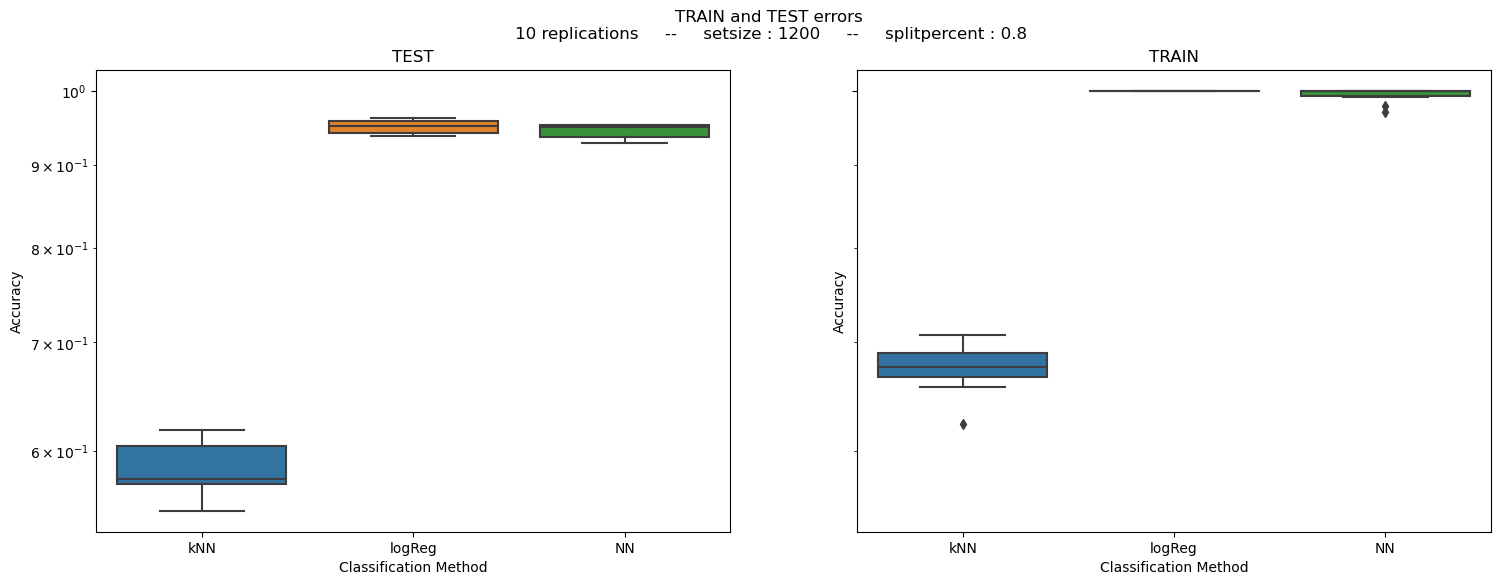

In [67]:
fig, axs = plt.subplots(figsize = (18,6 ), ncols=2,sharey=True)

fig.suptitle(
    'TRAIN and TEST errors \n{} replications     --     setsize : {}     --     splitpercent : {}'.format(
                    iterations.size, setsize,  splitpercent))

axs[0].set_title('TEST')
sns.boxplot(data= pd.DataFrame.from_dict(TEST_ACCS, orient='index').transpose(), ax= axs[0])
axs[0].set_xlabel('Classification Method'); axs[0].set_ylabel('Accuracy')

axs[1].set_title('TRAIN')
sns.boxplot(data= pd.DataFrame.from_dict(TRAIN_ACCS, orient='index').transpose(), ax= axs[1])
axs[1].set_xlabel('Classification Method'); axs[1].set_ylabel('Accuracy')

axs[1].set_yscale('log')
plt.show()

### setsize 12000

In [197]:
setsize = 12000
iterations = np.arange(10)

In [198]:
TRAIN_ACCS = {}
TEST_ACCS = {}

for method, fun in zip(['logReg', 'NN'], [FullLogReg, NeuralNetwork]):
    start_time = time.time()

    _TRAIN_ACCS = []
    _TEST_ACCS = []

    for iter_ in tqdm(iterations):
        train_acc, test_acc = fun(DataSample,setsize = setsize, splitpercent = splitpercent); 
        _TRAIN_ACCS.append(train_acc)
        _TEST_ACCS.append(test_acc)
    TRAIN_ACCS.update({method: _TRAIN_ACCS})
    TEST_ACCS.update({method: _TEST_ACCS})
    end_time = time.time()
    print("Execution time for {} : {}s".format(method, round(end_time - start_time)))

100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Execution time for logReg : 18s


100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.38s/it]

Execution time for NN : 74s


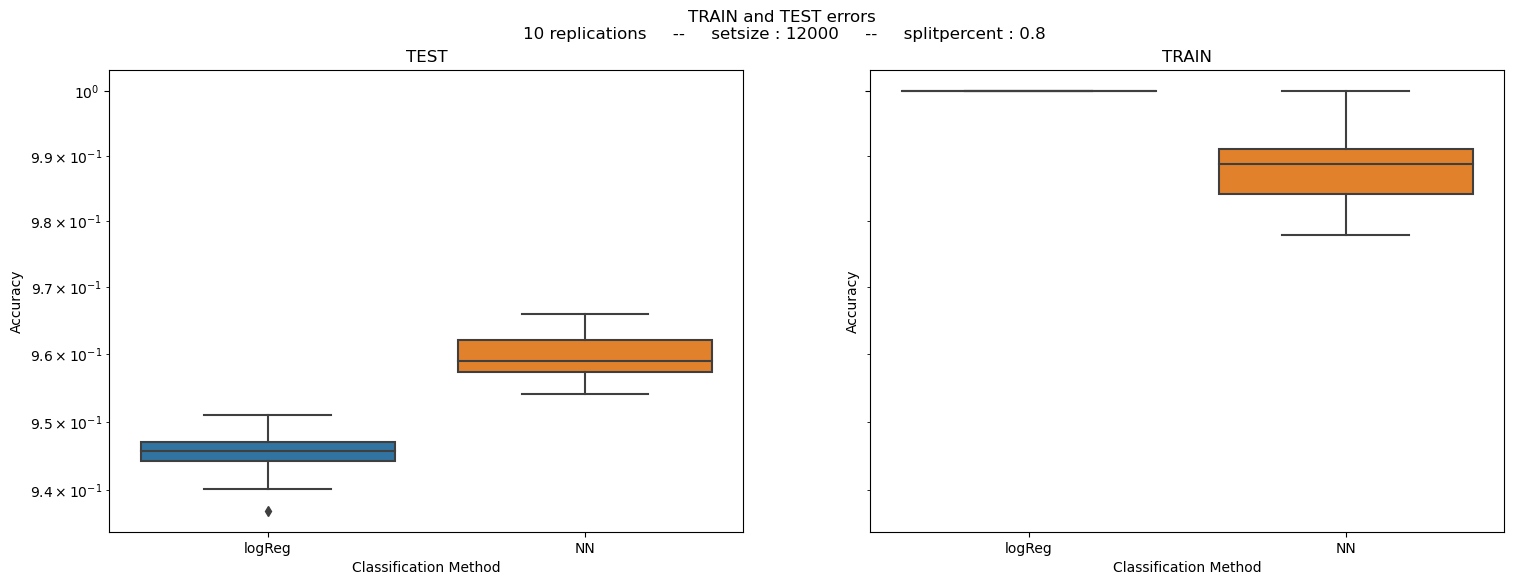

In [199]:
fig, axs = plt.subplots(figsize = (18,6 ), ncols=2,sharey=True)

fig.suptitle(
    'TRAIN and TEST errors \n{} replications     --     setsize : {}     --     splitpercent : {}'.format(
                    iterations.size, setsize,  splitpercent))

axs[0].set_title('TEST')
sns.boxplot(data= pd.DataFrame.from_dict(TEST_ACCS, orient='index').transpose(), ax= axs[0])
axs[0].set_xlabel('Classification Method'); axs[0].set_ylabel('Accuracy')

axs[1].set_title('TRAIN')
sns.boxplot(data= pd.DataFrame.from_dict(TRAIN_ACCS, orient='index').transpose(), ax= axs[1])
axs[1].set_xlabel('Classification Method'); axs[1].set_ylabel('Accuracy')

axs[1].set_yscale('log')
plt.show()

## Tuning the NN

###  setsize 1200

In [204]:
NN_TRAIN_ACCS = {}
NN_TEST_ACCS = {}

setsize = 1200
iterations = np.arange(3)

for optimizer in ['adam','SGD']:
    
    for output_activation in ['sigmoid', 'tanh']:
        
        for width in tqdm([1,5,10,20]):

            for layers in [1,2,4,8]:
                _TRAIN_ACCS = []
                _TEST_ACCS = []

                for _ in iterations:
                    train_acc, test_acc = fun(DataSample,setsize = setsize, splitpercent = splitpercent); 
                    _TRAIN_ACCS.append(train_acc)
                    _TEST_ACCS.append(test_acc)

                NN_TRAIN_ACCS.update({(width,layers,hidden_activation,output_activation,optimizer
                                      ):np.median(_TRAIN_ACCS)})
                NN_TEST_ACCS.update({(width,layers,hidden_activation,output_activation,optimizer
                                     ):np.median(_TEST_ACCS)})

100%|█████████████████████████████████████████████| 4/4 [01:26<00:00, 21.69s/it]


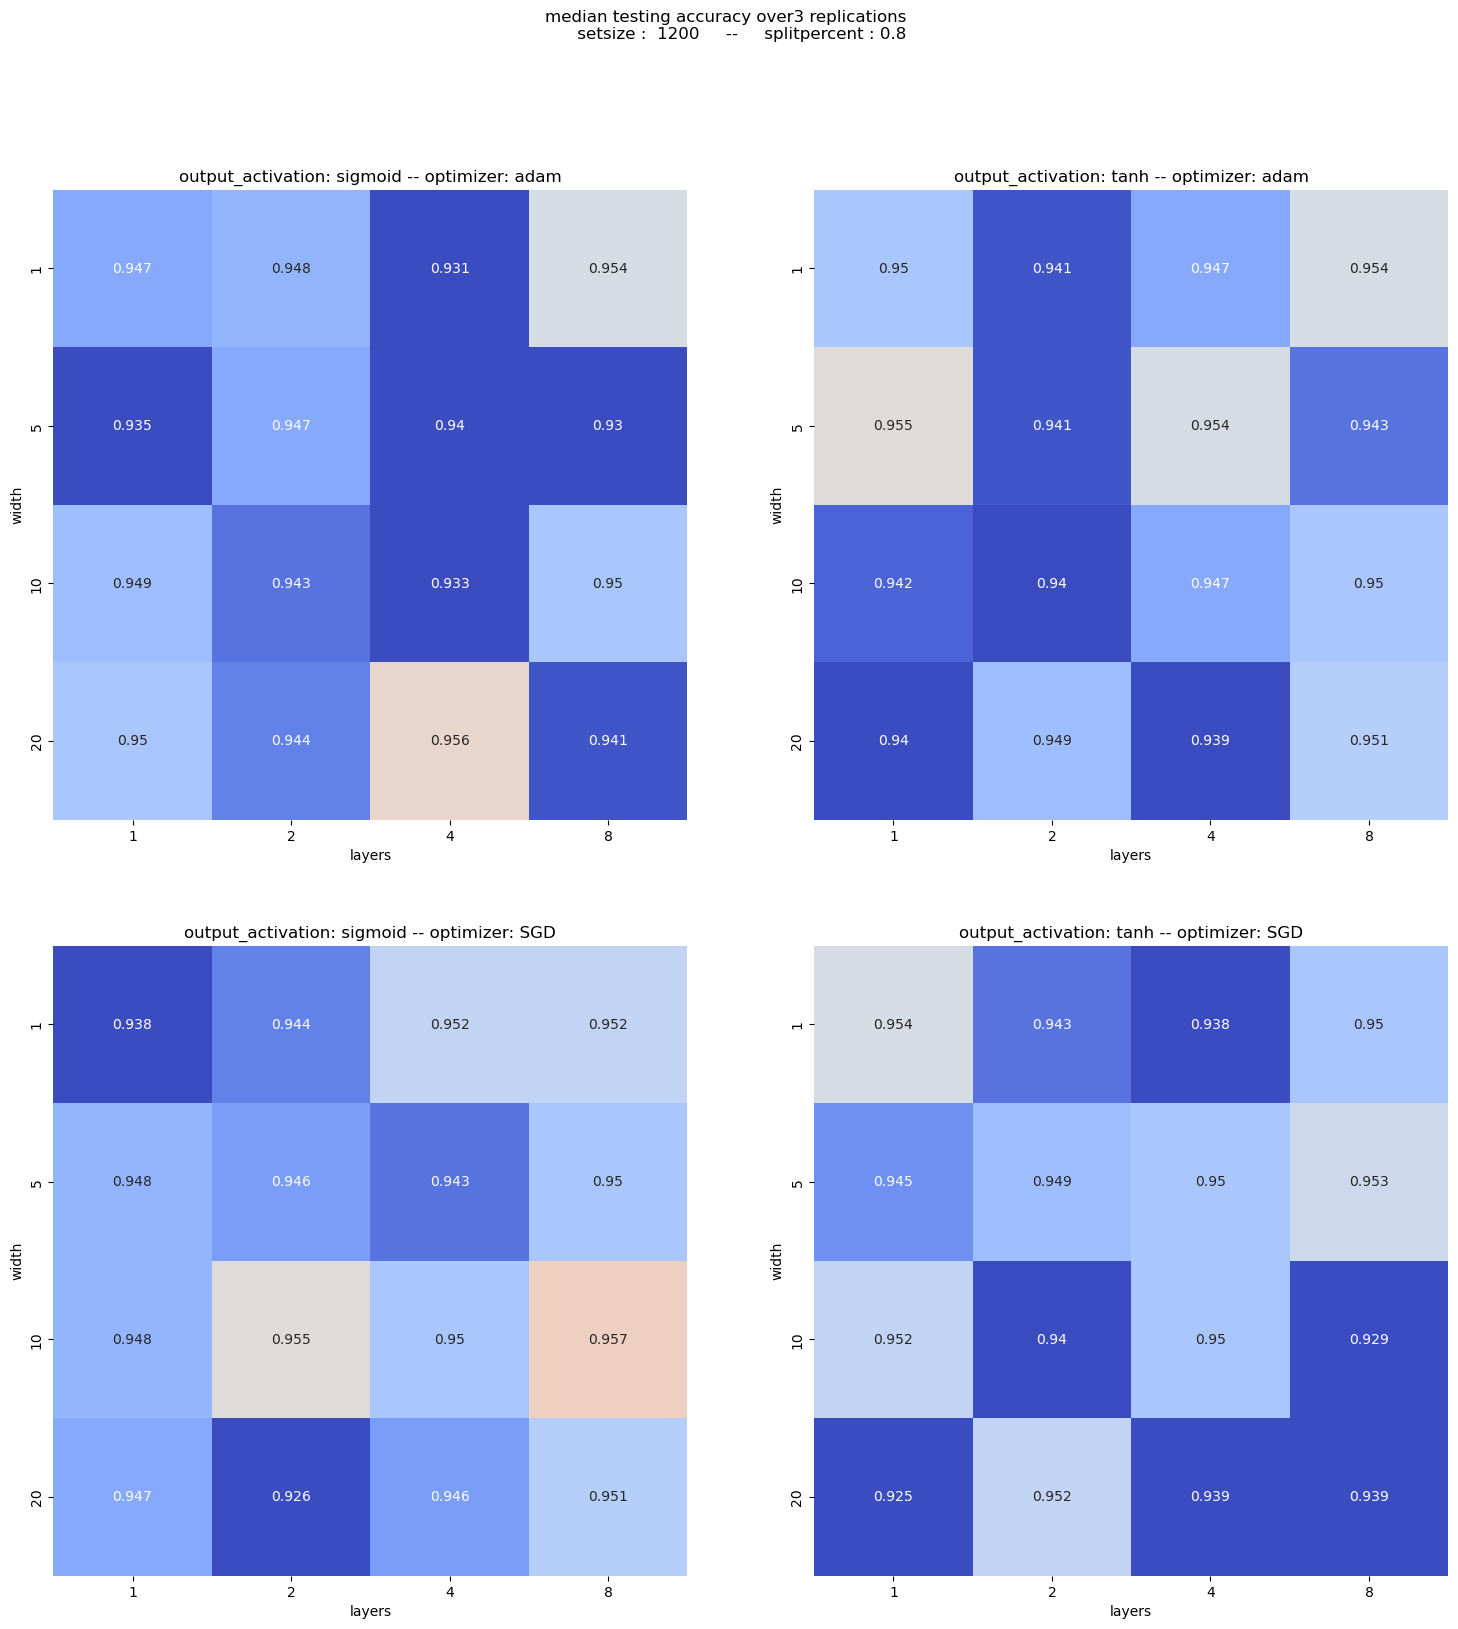

In [206]:
fig,axs = plt.subplots(figsize = (18,18), ncols=2,nrows=2); axs=axs.ravel()

fig.suptitle(
    'median testing accuracy over{} replications \n\
     setsize :  {}     --     splitpercent : {}'.format(iterations.size, setsize,  splitpercent))
i=0
for optimizer in ['adam','SGD']:
    for output_activation in ['sigmoid', 'tanh']:
    
        M_accs = []
        for key in NN_TEST_ACCS.keys():
            if  (key[2] == hidden_activation) & (key[3] == output_activation) & (key[4] == optimizer):
                M_accs.append( [key[0], key[1], NN_TEST_ACCS[key]]) 

        df_accs = pd.DataFrame(data = M_accs, columns=['width', 'layers', 'accuracy'])


        ax=axs[i].set_title('output_activation: {} -- optimizer: {}'.format(output_activation,optimizer))
        sns.heatmap(df_accs.pivot('width', 'layers', 'accuracy'),
                    cbar=False, annot=True, cmap='coolwarm',fmt='.3g',ax=axs[i],vmin=0.94,vmax=0.97)
        
        i=i+1
        

----

###  setsize 12000

In [207]:
NN_TRAIN_ACCS = {}
NN_TEST_ACCS = {}

setsize = 12000
iterations = np.arange(3)

for optimizer in ['adam','SGD']:
    
    for output_activation in ['sigmoid', 'tanh']:
        
        for width in tqdm([1,5,10,20]):

            for layers in [1,2,4,8]:
                _TRAIN_ACCS = []
                _TEST_ACCS = []

                for _ in iterations:
                    train_acc, test_acc = fun(DataSample,setsize = setsize, splitpercent = splitpercent); 
                    _TRAIN_ACCS.append(train_acc)
                    _TEST_ACCS.append(test_acc)

                NN_TRAIN_ACCS.update({(width,layers,hidden_activation,output_activation,optimizer
                                      ):np.median(_TRAIN_ACCS)})
                NN_TEST_ACCS.update({(width,layers,hidden_activation,output_activation,optimizer
                                     ):np.median(_TEST_ACCS)})

100%|█████████████████████████████████████████████| 4/4 [06:07<00:00, 91.98s/it]


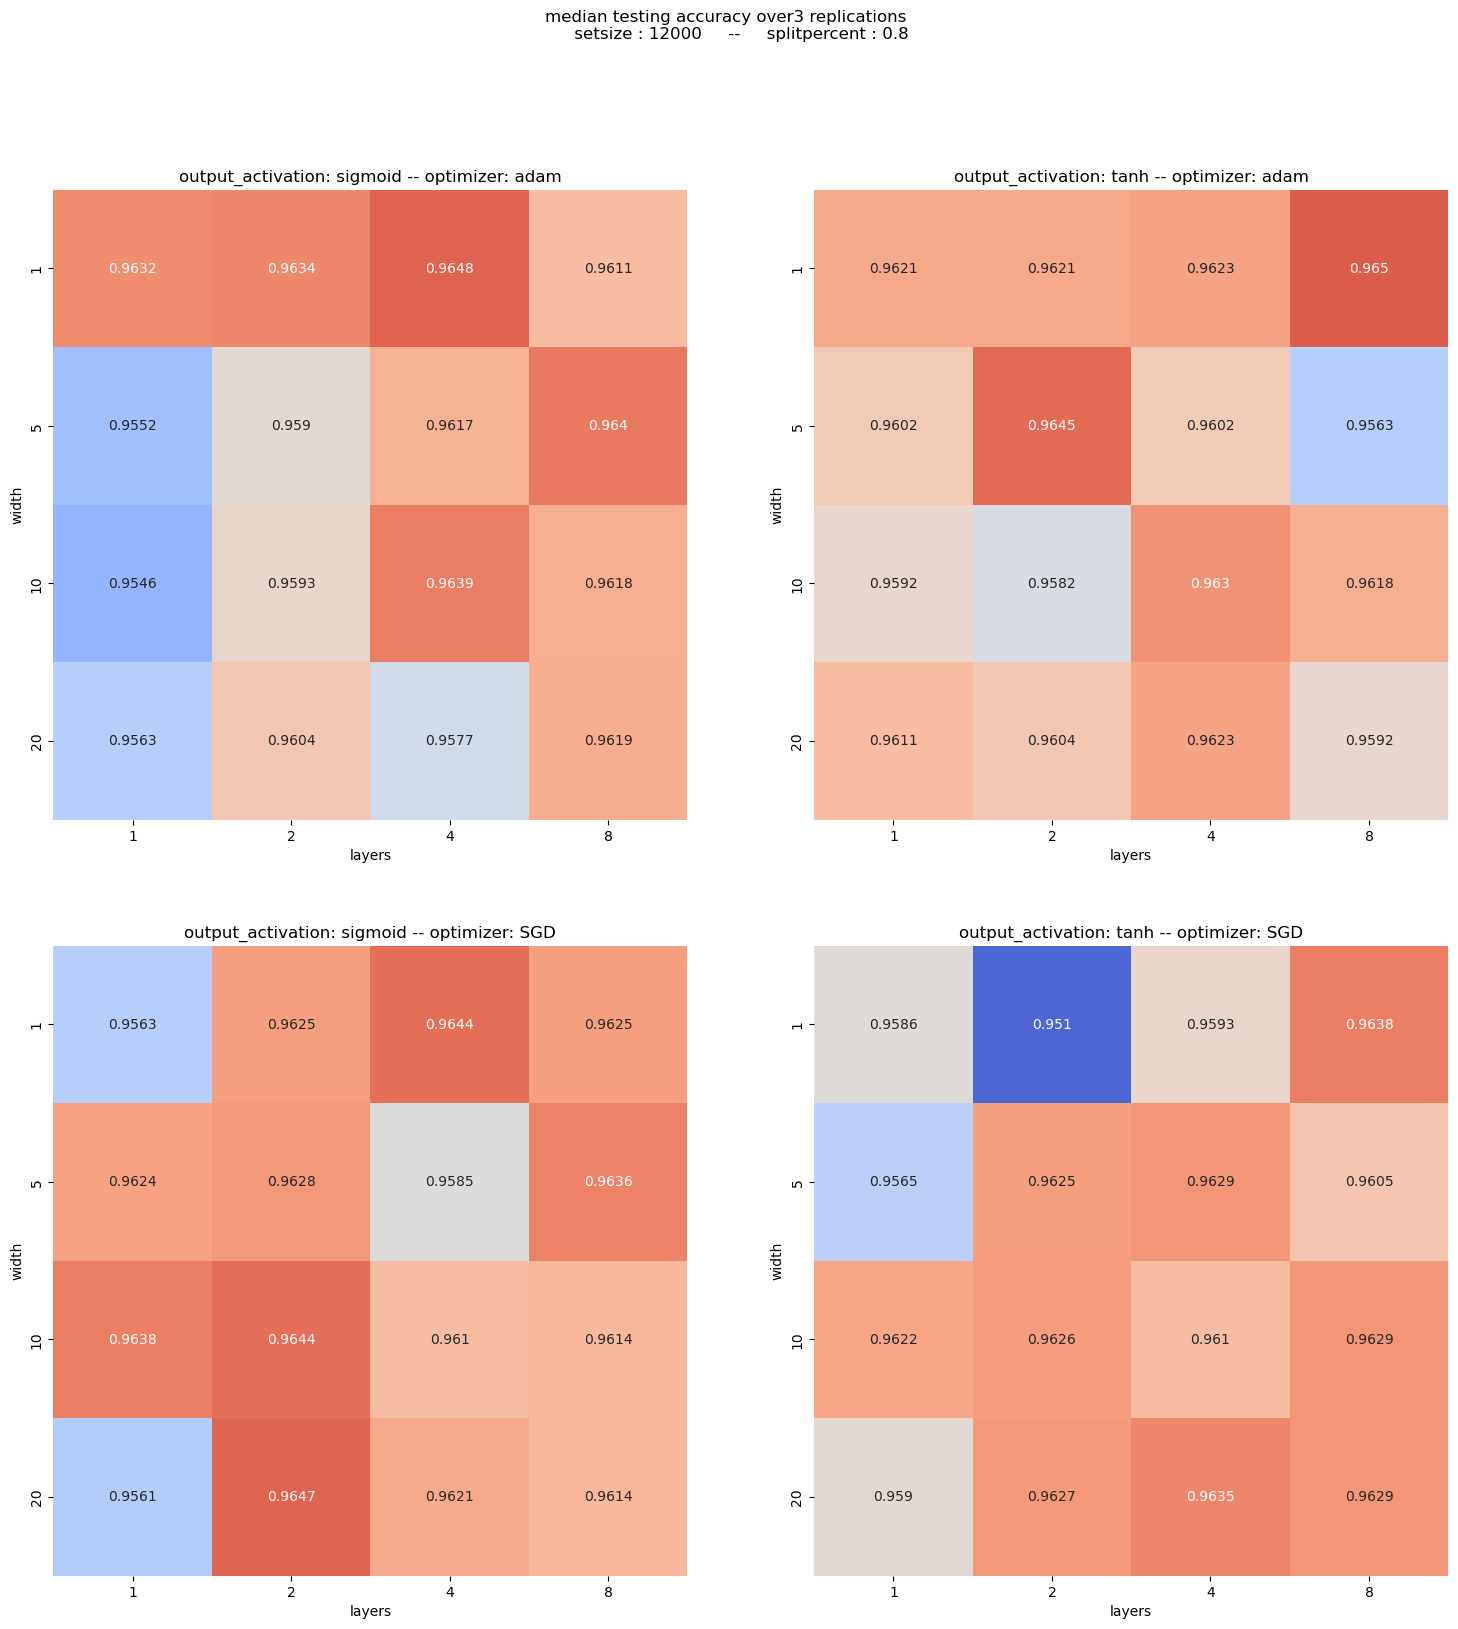

In [211]:
fig,axs = plt.subplots(figsize = (18,18), ncols=2,nrows=2); axs=axs.ravel()

fig.suptitle(
    'median testing accuracy over{} replications \n\
     setsize : {}     --     splitpercent : {}'.format(iterations.size, setsize,  splitpercent))
i=0
for optimizer in ['adam','SGD']:
    for output_activation in ['sigmoid', 'tanh']:
    
        M_accs = []
        for key in NN_TEST_ACCS.keys():
            if  (key[2] == hidden_activation) & (key[3] == output_activation) & (key[4] == optimizer):
                M_accs.append( [key[0], key[1], NN_TEST_ACCS[key]]) 

        df_accs = pd.DataFrame(data = M_accs, columns=['width', 'layers', 'accuracy'])


        ax=axs[i].set_title('output_activation: {} -- optimizer: {}'.format(output_activation,optimizer))
        sns.heatmap(df_accs.pivot('width', 'layers', 'accuracy'),
                    cbar=False, annot=True, cmap='coolwarm',fmt='.4g',ax=axs[i], vmin=0.95,vmax=0.967)
        
        i=i+1
        

----

----

----

----